# Projet 4 : Anticipez les besoins en consommation de bâtiments

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

# Nettoyage et exploration des données

<a id="0"></a> <br>
# Table of Contents  

1. [Nettoyage des données](#1)
    * [1.1 Premières observations](#2)
    * [1.2 Duplicata](#3)
    * [1.3 Filtres](#4)
    * [1.4 Traitement des formats](#5)
    * [1.5 Outliers](#6)
         * [1.5.a Colonne Outlier](#7)
         * [1.5.b Valeurs négatives](#8)
         * [1.5.c Incohérences](#9)
    * [1.6 Données manquantes](#10)
    * [1.7 Traitement des valeurs manquantes](#11)

1. [Feature Engineering](#12) 
1. [Analyse exploratoire](#13) 

In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import functions as fc
import folium
from folium.plugins import MarkerCluster

from sklearn.impute import KNNImputer
from scipy.stats import shapiro, pearsonr, spearmanr, kendalltau, kruskal, chi2_contingency
from sklearn.decomposition import PCA

import importlib

In [472]:
importlib.reload(fc)

<module 'functions' from '/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 4/functions.py'>

Les fonctions utilisées dans ce notebook sont présentées dans le fichier functions.py fournis.

In [367]:
# Paramètres d'affichage
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

##  <a id="1"></a> 1. Nettoyage des données
###  <a id="2"></a> 1.1 Premières observations

In [368]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [369]:
data_original = data.copy()

In [370]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [371]:
data.shape

(3376, 46)

In [372]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [373]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [374]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


**Explication des variables :**
- **OSEBuildingID** : identifiant unique attribué à chaque propriété couverte par la Seattle Benchmarking Ordinance à des fins de suivi et d'identification.
- **DataYear** : Année civile représentée par chaque enregistrement de données.
- **BuildingType** : Classification des types de bâtiments de la ville de Seattle.
- **PrimaryPropertyType** : L'utilisation principale d'une propriété (par exemple, bureau, magasin de détail). L'usage principal est défini comme une fonction qui représente plus de 50 % d'un bien. Il s'agit du champ Type de propriété - EPA calculée de Portfolio Manager.
- **PropertyName** : Nom de propriété officiel ou commun tel qu'il est entré dans le gestionnaire de portefeuille de l'EPA.
- **Address** : Adresse municipale de la propriété.
- **City** : Ville de la propriété.
- **State** : Etat de la propriété.
- **ZipCode** : Code postal de la propriété.
- **TaxParcelIdentificationNumber** : Code PIN du comté de King.
- **CouncilDistrictCode** : Propriété District du conseil de la ville de Seattle.
- **Neighborhood** : Zone de voisinage de propriété définie par le département des quartiers de la ville de Seattle.
- **Latitude** : Latitude de la propriété.
- **Longitude** : Longitude de la propriété.
- **YearBuilt** : Année au cours de laquelle une propriété a été construite ou a fait l'objet d'une rénovation complète.
- **NumberofBuildings** : Nombre de bâtiments inclus dans le rapport de la propriété. Dans les cas où une propriété est signalée comme un campus, plusieurs bâtiments peuvent être inclus dans un seul rapport.
- **NumberofFloors** : Nombre d'étages signalés dans Portfolio Manager.
- **PropertyGFATotal** : Surface de plancher brute totale du bâtiment et du stationnement.
- **PropertyGFAParking** : Espace total en square foot (0,09 m²) de tous les types de stationnement (entièrement fermé, partiellement fermé et ouvert).
- **PropertyGFABuilding(s)** : Espace au sol total en square foot (0,09 m²) entre les surfaces extérieures des murs d'enceinte d'un bâtiment. Cela comprend toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace des locataires, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc.
- **ListOfAllPropertyUseTypes** : Toutes les utilisations de la propriété signalées dans Portfolio Manager.
- **LargestPropertyUseType** : La plus grande utilisation d'une propriété (par exemple, bureau, magasin de détail) par GFA.
- **LargestPropertyUseTypeGFA** : La surface de plancher brute (GFA) de la plus grande utilisation de la propriété.
- **SecondLargestPropertyUseType** : La 2ème plus grande utilisation d'une propriété par GFA.
- **SecondLargestPropertyUseTypeGFA** : La surface de plancher brute (GFA) de la deuxième plus grande utilisation de la propriété.
- **ThirdLargestPropertyUseType** : La 3ème plus grande utilisation d'une propriété par GFA.
- **ThirdLargestPropertyUseTypeGFA** : La surface de plancher brute (GFA) de la troisième plus grande utilisation de la propriété.
- **YearsENERGYSTARCertified** : Années où la propriété a reçu la certification ENERGY STAR.
- **ENERGYSTARScore** : Une EPA a calculé une note de 1 à 100 qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales pour contrôler les différences entre le climat, les utilisations des bâtiments et les opérations. Un score de 50 représente la médiane nationale.
- **SiteEUI(kBtu/sf)** : L'intensité de consommation d'énergie du site (IUE) est la consommation d'énergie du site d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie du site est le montant annuel de toute l'énergie consommée par la propriété sur le site, tel qu'indiqué sur les factures de services publics. L'IE du site est mesurée en milliers d'unités thermiques britanniques (kBtu) par square foot (0,09 m²).
- **SiteEUIWN(kBtu/sf)** : L'intensité de consommation d'énergie du site (EUI) normalisée par les conditions météorologiques (WN) est l'énergie du site WN d'une propriété divisée par sa surface de plancher brute (en square foot (0,09 m²)). L'énergie du site WN est la consommation d'énergie du site que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans. L'IUE du site WN est mesurée en milliers d'unités thermiques britanniques (kBtu) par square foot (0,09 m²).
- **SourceEUI(kBtu/sf)** : L'intensité de consommation d'énergie à la source (IUE) est la consommation d'énergie à la source d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie à la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de production, de transmission et de distribution. Source EUI est mesurée en milliers d'unités thermiques britanniques (kBtu) par square foot (0,09 m²).
- **SourceEUIWN(kBtu/sf)**: L'intensité d'utilisation de l'énergie à la source (EUI) normalisée par les conditions météorologiques (WN) est l'énergie à la source WN d'une propriété divisée par sa surface de plancher brute. L'énergie à la source WN est l'utilisation de l'énergie à la source que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans. WN Source EUI est mesuré en milliers d'unités thermiques britanniques (kBtu) par square foot (0,09 m²).
- **SiteEnergyUse(kBtu)** : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.
- **SiteEnergyUseWN(kBtu)** : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé dans des conditions météorologiques moyennes sur 30 ans.
- **SteamUse(kBtu)** : La quantité annuelle de vapeur de quartier consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).
- **Electricity(kWh)** : La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes renouvelables sur place, mesurée en kWh.
- **Electricity(kBtu)** : mesurée en milliers d'unités thermiques britanniques (kBtu).
- **NaturalGas(therms)**: La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en thermes.
- **NaturalGas(kBtu)** : mesurée en milliers d'unités thermiques britanniques (kBtu).
- **DefaultData** : La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété.
- **Comments** : Commentaires d'un propriétaire ou d'un agent du bâtiment pour mettre en contexte la consommation d'énergie du bâtiment.
- **ComplianceStatus** : Si une propriété a satisfait aux exigences d'analyse comparative énergétique pour l'année de déclaration en cours.
- **Outlier** : Si une propriété est une valeur aberrante élevée ou basse (O/N).
- **TotalGHGEmissions** : La quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde nitreux libérés dans l'atmosphère à la suite de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent dioxyde de carbone. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lb CO2e/MWh jusqu'à ce que le facteur 2016 soit disponible. Facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. Facteur de gaz provenant de EPA Portfolio Manager = 53,11 kg CO2e/MBtu.
- **GHGEmissionsIntensity** : Émissions totales de gaz à effet de serre divisées par la surface de plancher brute de la propriété, mesurée en kilogrammes d'équivalent en dioxyde de carbone par square foot (0,09 m²). Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light.



###  <a id="3"></a> 1.2 Duplicata

In [375]:
fc.data_duplicated(data)

0

Nous pouvons analyser les doublons grâce à la variable *OSEBuildingID* qui est supposée être unique car elle représente un identifiant unique attribué à chaque propriété couverte par la Seattle Benchmarking Ordinance à des fins de suivi et d'identification.

In [376]:
fc.row_duplicated(data,'OSEBuildingID')

0

Le data set ne comporte pas de doublons.

###  <a id="4"></a> 1.3 Filtres

La consigne nous indique de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments **non destinés à l’habitation**. Nous allons donc supprimer de notre dataframe les bâtiments destinés à l'habitation.

In [377]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [378]:
data['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [379]:
data = data[~data['BuildingType'].str.contains("Multifamily") 
           ]
print(data.shape)

(1668, 46)


In [380]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

Cela réduit notre dataframe à 1 668 observations. 

Nous allons désormais étudier la variable *ComplianceStatus*.

In [381]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [382]:
data.loc[(data['ComplianceStatus']=='Compliant')].shape

(1548, 46)

La plupart des données sont étiquettées *'Compliant'*. On décide donc de filtrer notre data frame sur cette nouvelle condition afin de supprimer les éventuelles lignes pouvant comporter des erreurs.

In [383]:
data = data.loc[(data['ComplianceStatus']=='Compliant')]

In [384]:
data.shape

(1548, 46)

In [385]:
data.drop('ComplianceStatus',axis=1,inplace=True)

###  <a id="5"></a> 1.4 Traitement des formats

In [386]:
cols_upper = ['PropertyName','Neighborhood' ,'Address']
data[cols_upper] = data[cols_upper].applymap(str.upper)

In [387]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [388]:
data['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace = True)

###  <a id="6"></a> 1.5 Outliers

#### <a id="7"></a> 1.5.a Colonne Outlier

Analysons tout d'abord la colonne *Outlier*.

In [392]:
data['Outlier'].unique()

array([nan], dtype=object)

In [393]:
data.loc[~data["Outlier"].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


En filtrant le dataframe par données *'Compliant'* cela a également supprimé les valeurs considérées comme outliers par la variable *'Outlier'*. Cette variable ne nous est donc plus utile. 

Regardons désormais si il existe d'autres outliers qui n'étaient pas considérés par la variable.

#### <a id="8"></a> 1.5.b Valeurs négatives

In [394]:
data.min()

OSEBuildingID                                        1
DataYear                                          2016
BuildingType                                    Campus
PrimaryPropertyType                Distribution Center
PropertyName                          #4706 BITTERLAKE
Address                                10 HARRISON ST.
City                                           Seattle
State                                               WA
ZipCode                                        98006.0
TaxParcelIdentificationNumber               0001800033
CouncilDistrictCode                                  1
Neighborhood                                   BALLARD
Latitude                                      47.50959
Longitude                                   -122.41182
YearBuilt                                         1900
NumberofBuildings                                  0.0
NumberofFloors                                       0
PropertyGFATotal                                 11285
PropertyGF

Nous n'avons pas de valeurs négatives qui semblent aberrantes. En effet, les énergies négatives peuvent être dues au fait que certains bâtiments sont producteurs d'énergie (avec des panneaux solaires par exemple), et consomment donc moins d'énergie qu'ils n'en produisent. Ces valeurs sont donc atypiques mais pas aberrantes. 

Nous verrons comment les exploiter lors de la phase de modélisation. 

En revanche nous avons des valeurs nulles pour *NumberofBuildings* et *NumberofFloors*.

In [395]:
data.loc[data['NumberofBuildings']==0].shape

(52, 45)

In [397]:
data.loc[data['NumberofBuildings']==0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
63,89,2016,NonResidential,Medical Office,POLYCLINIC NORTH && SOUTH,1200 HARVARD AVE,Seattle,WA,98122.0,1978201270,3,EAST,47.612440,-122.321400,1965,0.0,3,179014,0,179014,Medical Office,Medical Office,179014.0,NaN,NaN,NaN,NaN,NaN,48.0,93.300003,92.300003,213.399994,210.300003,1.670106e+07,1.652771e+07,0.000000e+00,2.897563e+06,9886484.0,68145.703130,6814570.0,False,NaN,NaN,430.84,2.41
76,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 MERCER ST,Seattle,WA,98109.0,1988200705,7,MAGNOLIA / QUEEN ANNE,47.623910,-122.348370,1986,0.0,2,66240,2352,63888,"Data Center, Distribution Center, Office, Park...",Office,45900.0,Data Center,5181.0,Distribution Center,4551.0,NaN,NaN,74.900002,75.400002,235.199997,236.600006,4.166306e+06,4.192108e+06,0.000000e+00,1.221074e+06,4166305.0,0.000000,0.0,False,NaN,NaN,29.04,0.44
160,257,2016,NonResidential,Warehouse,HARBOR ISLAND: WAREHOUSE E - DNRP-SWD,3235 16TH AVE SW,Seattle,WA,98134.0,7666703020,1,GREATER DUWAMISH,47.575070,-122.357470,1916,0.0,4,79600,0,79600,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,79600.0,NaN,NaN,NaN,NaN,NaN,34.0,30.299999,30.299999,95.099998,95.099998,2.411402e+06,2.411402e+06,0.000000e+00,7.067415e+05,2411402.0,0.000000,0.0,False,NaN,NaN,16.81,0.21
201,322,2016,NonResidential,Large Office,COX MEDIA GROUP SEATTLE KIRO TV (322),2801 3RD AVE,Seattle,WA,98121.0,0656000005,7,DOWNTOWN,47.617570,-122.351220,1968,0.0,3,100734,26731,74003,Office,Office,100734.0,NaN,NaN,NaN,NaN,NaN,20.0,97.199997,98.199997,305.100006,308.399994,9.788717e+06,9.892566e+06,0.000000e+00,2.868908e+06,9788716.0,0.000000,0.0,False,NaN,NaN,68.24,0.68
241,366,2016,NonResidential,Small- and Mid-Sized Office,UNIVERSITY DISTRICT OFFICE BUIDING,1107 NE 45TH ST,Seattle,WA,98105.0,1142000500,4,NORTHEAST,47.661000,-122.316260,1961,0.0,5,99005,0,99005,Office,Office,79555.0,NaN,NaN,NaN,NaN,NaN,70.0,59.400002,63.000000,137.600006,140.699997,4.728488e+06,5.008124e+06,0.000000e+00,8.391593e+05,2863212.0,18652.765630,1865277.0,False,NaN,NaN,119.03,1.20
264,391,2016,NonResidential,Mixed Use Property,THAW BUILDING,8300 MILITARY RD SOUTH,Seattle,WA,98108.0,0007400015,2,GREATER DUWAMISH,47.528710,-122.294430,1970,0.0,1,88400,0,88400,"Distribution Center, Non-Refrigerated Warehous...",Non-Refrigerated Warehouse,33450.0,Office,29620.0,Distribution Center,27715.0,NaN,42.0,48.299999,53.000000,109.000000,113.900002,4.383100e+06,4.811200e+06,0.000000e+00,7.416934e+05,2530658.0,18524.421880,1852442.0,False,NaN,NaN,116.03,1.31
278,408,2016,NonResidential,Large Office,FOURTH AND PIKE BUILDING,1424 4TH AVE,Seattle,WA,98101.0,1975700235,7,DOWNTOWN,47.610050,-122.336100,1926,0.0,10,132326,0,132326,"Office, Other, Retail Store",Office,92006.0,Other,12610.0,Retail Store,9835.0,NaN,72.0,52.700001,53.700001,159.800003,163.000000,6.029020e+06,6.146692e+06,3.282471e+05,1.670053e+06,5698221.0,25.510000,2551.0,False,NaN,NaN,65.20,0.49
280,410,2016,NonResidential,Hotel,MOTIF SEATTLE,1414 4TH AVE,Seattle,WA,98101.0,1975700255,7,DOWNTOWN,47.609960,-122.335720,1973,0.0,19,332067,59280,272787,Hotel,Hotel,332067.0,NaN,NaN,NaN,NaN,NaN,6.0,113.800003,114.400002,251.300003,249.300003,3.778555e+07,3.798415e+07,1.558601e+07,5.803207e+06,19800542.0,23989.9492

In [398]:
index_buildings = data.loc[data['NumberofBuildings']==0].index

In [399]:
data.loc[data['NumberofFloors']==0].shape

(16, 45)

In [400]:
data.loc[data['NumberofFloors']==0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
166,267,2016,NonResidential,Hotel,GRAND HYATT SEATTLE,721 PINE ST,Seattle,WA,98101.0,6792120000,7,DOWNTOWN,47.61275,-122.33330,1999,1.0,0,934292,0,934292,"Hotel, Other, Parking, Restaurant, Retail Store",Hotel,495536.0,Parking,438756.0,Restaurant,49700.0,NaN,NaN,117.900002,120.500000,272.899994,278.200012,6.504728e+07,66502836.0,0.0,1.153696e+07,39364114.0,256831.625000,25683162.0,False,NaN,NaN,1638.46,1.75
487,656,2016,NonResidential,Medical Office,ARNOLD PAVILION,1221 MADISON STREET,Seattle,WA,98104.0,8725990000,3,EAST,47.60979,-122.32298,2004,1.0,0,225982,0,225982,Medical Office,Medical Office,200184.0,NaN,NaN,NaN,NaN,NaN,53.0,102.699997,103.699997,246.899994,245.300003,2.056062e+07,20764814.0,7815663.0,3.735333e+06,12744957.0,0.000000,0.0,False,NaN,NaN,692.12,3.06
488,657,2016,NonResidential,Mixed Use Property,2200 WESTLAKE - SEDO,2200 WESTLAKE AVE.,Seattle,WA,98121.0,8729740000,7,DOWNTOWN,47.61783,-122.33729,2006,0.0,0,516407,0,516407,"Financial Office, Hotel, Multifamily Housing, ...",Parking,385196.0,Multifamily Housing,340236.0,Hotel,67627.0,NaN,31.0,76.300003,78.900002,199.199997,202.000000,3.940332e+07,40754364.0,0.0,8.626261e+06,29432803.0,99705.117190,9970512.0,False,NaN,NaN,734.72,1.42
564,758,2016,NonResidential,Other,PACIFIC PLACE,600 PINE STREET,Seattle,WA,98101.0,6600470000,7,DOWNTOWN,47.61289,-122.33531,1999,1.0,0,947987,0,947987,"Office, Other - Entertainment/Public Assembly,...",Other - Mall,561684.0,Other - Entertainment/Public Assembly,100000.0,Restaurant,80000.0,NaN,NaN,62.299999,62.099998,195.600006,194.899994,4.651096e+07,46343304.0,0.0,1.363158e+07,46510954.0,0.000000,0.0,False,NaN,NaN,324.25,0.34
1754,23311,2016,NonResidential,Medical Office,HART FIRST HILL LLC,1124 COLUMBIA STREET,Seattle,WA,98104.0,8590900646,3,EAST,47.60862,-122.32372,1945,1.0,0,274568,0,274568,"Medical Office, Parking",Medical Office,228133.0,Parking,135954.0,NaN,NaN,NaN,52.0,111.000000,111.199997,235.500000,233.100006,2.531153e+07,25358122.0,13296249.0,3.521476e+06,12015275.0,0.000000,0.0,False,NaN,NaN,1110.07,4.04
1993,24086,2016,Campus,Other,(ID#24086)CAMPUS1:KC METRO TRANSIT ATLANTIC CE...,1333 AIRPORT WAY S,Seattle,WA,98134.0,7666203387,2,GREATER DUWAMISH,47.59042,-122.32498,1991,10.0,0,230971,0,230971,"Other, Parking",Other,230970.0,Parking,0.0,NaN,NaN,NaN,NaN,91.000000,96.199997,235.100006,242.199997,2.102229e+07,22230844.0,0.0,4.519276e+06,15419770.0,56025.152340,5602515.0,False,NaN,NaN,405.05,1.75
3130,40028,2016,NonResidential,Warehouse,SANDPOINT #5,7561 63RD AVE NE,Seattle,WA,98115.0,0225049077,4,NORTHEAST,47.68454,-122.26235,1940,1.0,0,384772,0,384772,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,349953.0,Office,63872.0,NaN,NaN,NaN,69.0,36.700001,39.000000,84.099998,86.500000,1.520676e+07,16139557.0,0.0,2.642108e+06,9014872.0,61918.878910,6191888.0,False,NaN,NaN,391.70,1.02
3131,40031,2016,NonResidential,Medical Office,SANDPOINT #25,6222 NE 74TH ST,Seattle,WA,98115.0,0225049077,4,NORTHEAST,47.68240,-122.26223,1960,1.0,0,30287,0,30287,Medical Office,Medical Office,28050.0,NaN,NaN,NaN,NaN,NaN,32.0,78.199997,81.300003,217.399994,220.600006,2.193115e+06,2279632.5,0.0,5.320647e+05,1815405.0,3777.100342,377710.0,False,NaN,NaN,32.72

On décide de supprimer ces observations.

In [401]:
index_floors = data.loc[data['NumberofFloors']==0].index

In [403]:
fc.drop_lignes(data,index_buildings)
fc.drop_lignes(data,index_floors)

Suppression effectuée
Suppression effectuée


#### <a id="9"></a> 1.5.c Incohérences

In [405]:
# GFA buildings + parkings vs GFA total
data.loc[data["PropertyGFABuilding(s)"]+ data["PropertyGFAParking"] > data["PropertyGFATotal"]].shape

(0, 45)

Il n'y a aucune incohérence entre la surface de bâtiment plus la surface de parking et la surface totale.

###  <a id="10"></a> 1.6 Données manquantes

In [407]:
fc.missing_general(data)

Nombre total de cellules manquantes : 8546
Nombre de cellules manquantes en % : 12.82%


In [408]:
fc.valeurs_manquantes(data)

,Variable,Missing values,Missing (%)
0,OSEBuildingID,0,0.000000
1,DataYear,0,0.000000
2,BuildingType,0,0.000000
3,PrimaryPropertyType,0,0.000000
4,PropertyName,0,0.000000
5,Address,0,0.000000
6,City,0,0.000000
7,State,0,0.000000
8,ZipCode,13,0.008778
9,TaxParcelIdentificationNumber,0,0.000000


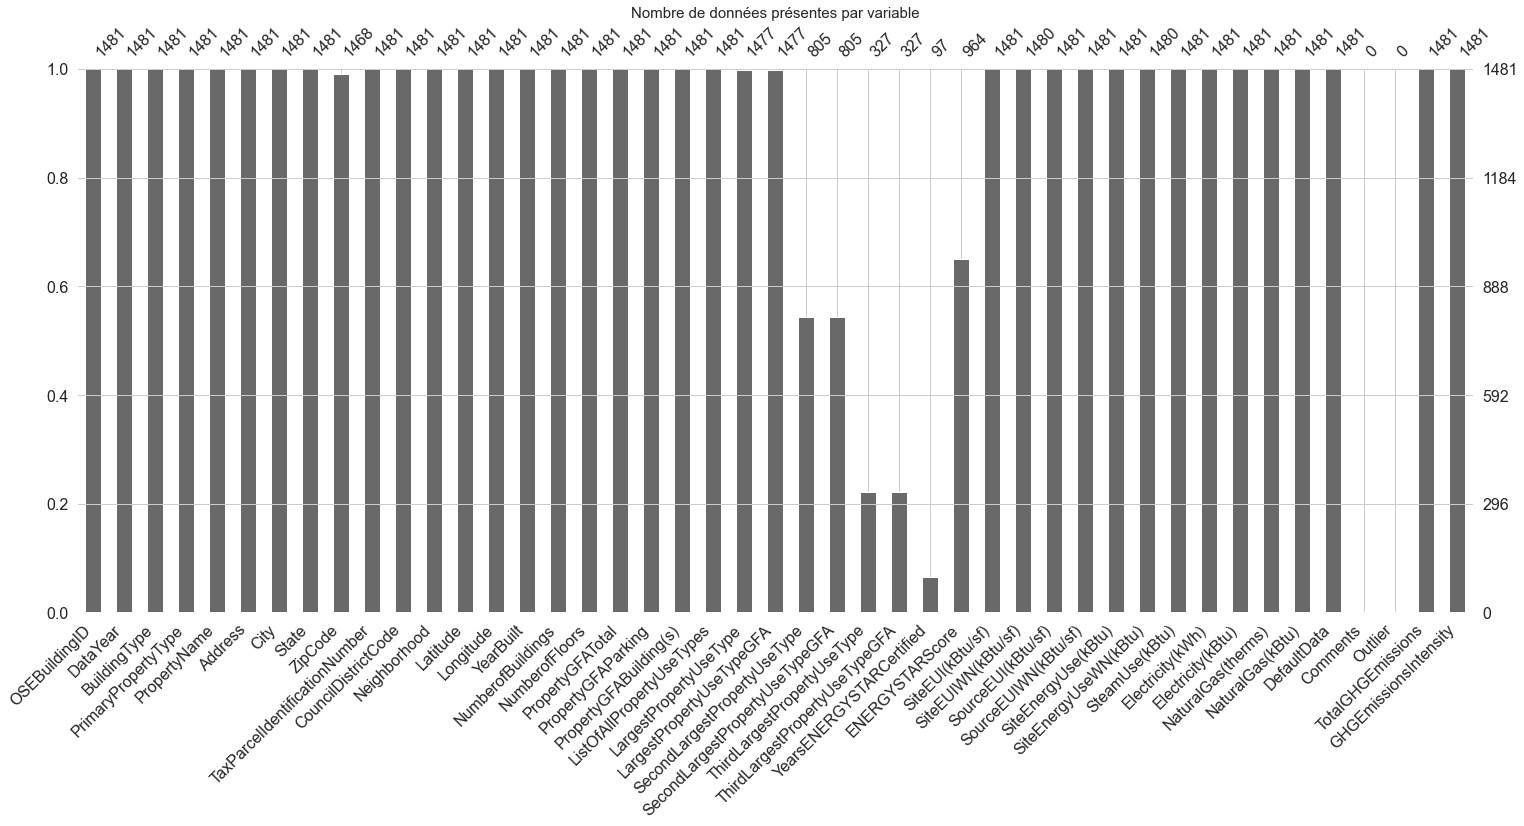

In [409]:
fc.bar_missing(data)

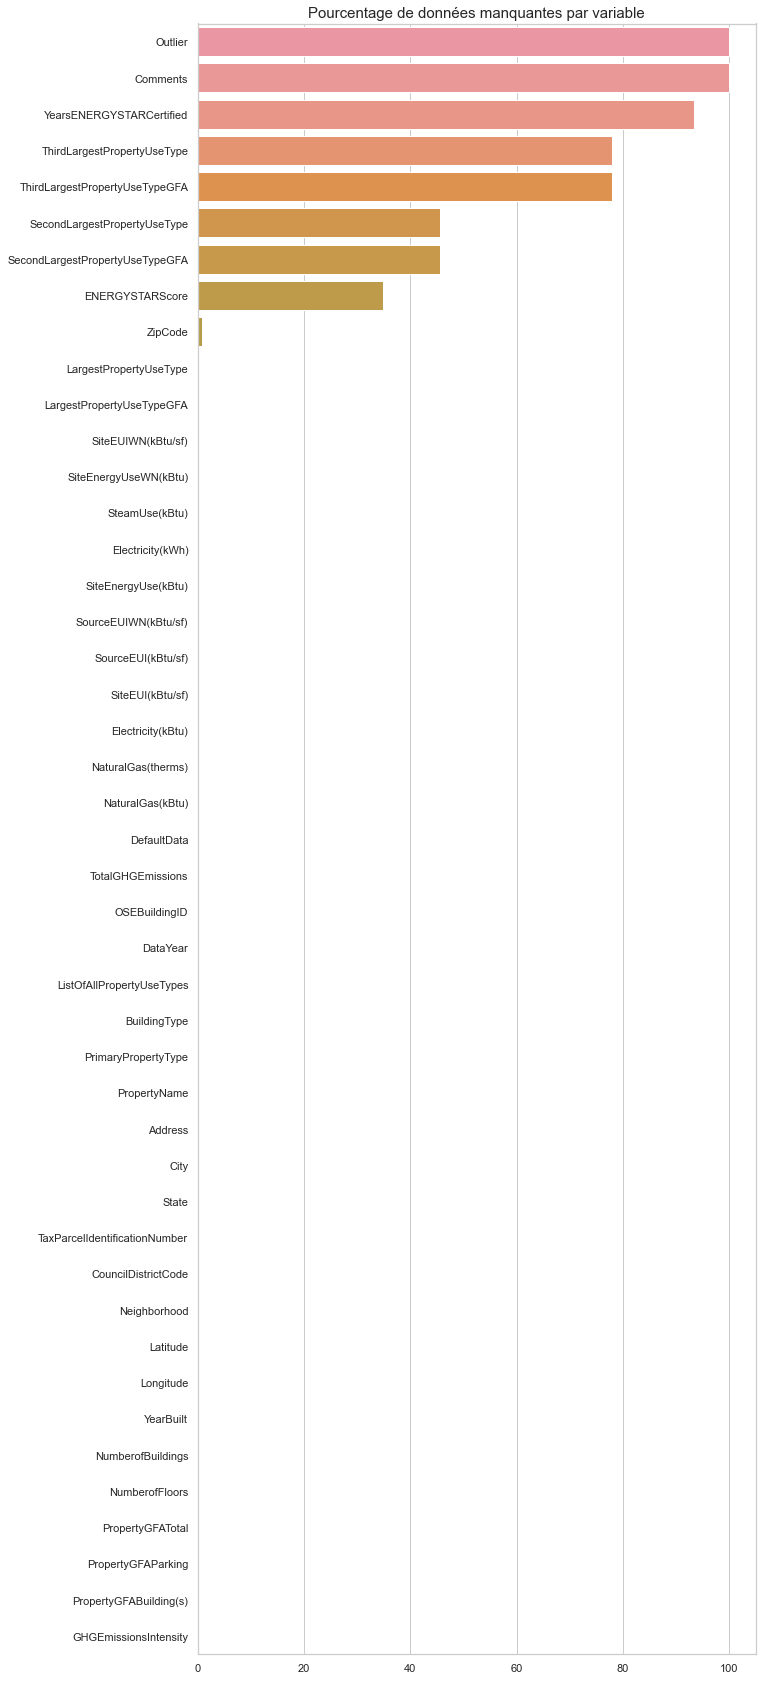

In [410]:
fc.barplot_missing(data)

On décide de supprimer les colonnes avec plus de 90% de données manquantes. 

In [411]:
data = fc.drop_columns_empty(data,0.9)

Suppression de la variable YearsENERGYSTARCertified avec % de valeurs manquantes 0.93
Suppression de la variable Comments avec % de valeurs manquantes 1.0
Suppression de la variable Outlier avec % de valeurs manquantes 1.0


La colonne *Comments* ne contenait aucune données. La colonne *YearsENERGYSTARCertified* n'était que trop peu remplie et de ce fait inutile pour notre étude. 

In [412]:
data.shape

(1481, 42)

###  <a id="11"></a> 1.7 Traitement des valeurs manquantes

Nous allons désormais réaliser le traitement des valeurs manquantes. 

Pour la plupart des variables, il manque moins d'une dizaine de valeurs.

In [413]:
data.loc[data['LargestPropertyUseType'].isna()].shape

(4, 42)

In [414]:
index_drop = data.loc[data['LargestPropertyUseType'].isna()].index

In [415]:
fc.drop_lignes(data,index_drop)

Suppression effectuée


In [416]:
data.shape

(1477, 42)

Il n'est pas très cohérent que le bâtiment ne possède aucune donnée pour cette variable. Il n'y a que 4 valeurs, nous décidons donc de les supprimer. 

En revanche, pour les variables *SecondLargestPropertyUseType*, *SecondLargestPropertyUseTypeGFA*, *ThirdLargestPropertyUseType* et *ThirdLargestPropertyUseTypeGFA*, leurs valeurs manquantes peuvent signifier que le bâtiment ne possède pas d'autre utilisation que la principale. Nous pouvons donc remplacer ces valeurs par 0 ou *'None'* en fonction de la nature de la variable.

In [417]:
data[['SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']] = data[['SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']].fillna(0)
data[['SecondLargestPropertyUseType','ThirdLargestPropertyUseType']] = data[['SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].fillna('None')

In [418]:
fc.valeurs_manquantes(data)

,Variable,Missing values,Missing (%)
0,OSEBuildingID,0,0.000000
1,DataYear,0,0.000000
2,BuildingType,0,0.000000
3,PrimaryPropertyType,0,0.000000
4,PropertyName,0,0.000000
5,Address,0,0.000000
6,City,0,0.000000
7,State,0,0.000000
8,ZipCode,13,0.008802
9,TaxParcelIdentificationNumber,0,0.000000


In [419]:
# Enregistrement des données nettoyées avant la sélection des features
data.to_csv('data_all_cleaned.csv', index=False)

##  <a id="12"></a> 2. Feature Engineering

In [420]:
data_final = data.copy()

On commence par supprimer les variables qui nous seront inutiles.

In [421]:
cols_to_drop = ['PropertyName','Address','City','State','ZipCode','TaxParcelIdentificationNumber',
                'ListOfAllPropertyUseTypes', 'DefaultData'
                ]

In [422]:
data_final = data_final.drop(cols_to_drop,axis=1)

Nous allons créer une variable qui détermine l'âge du bâtiment au lieu d'exploiter l'année de construction et la date des données. 

In [423]:
data_final['BuildingAge'] = data_final['DataYear']-data_final['YearBuilt']

In [424]:
data_final = data_final.drop(['DataYear','YearBuilt'],axis=1)

On va créer de nouvelles variables booléennes qui détermineront si un bâtiment consomme tel ou tel type d'énergie. C'est une donnée qui peut être renseignée lors de la construction du bâtiment.

In [425]:
# Electricity use
data_final['ElectricityUse'] = (data_final['Electricity(kBtu)']>0).astype('category')

# Steam use
data_final['SteamUse'] = (data_final['SteamUse(kBtu)']>0).astype('category')

# NaturalGas use
data_final['NaturalGasUse'] = (data_final['NaturalGas(kBtu)']>0).astype('category')

Nous allons désormais déterminer quelle est l'énergie la plus utilisée pour chaque bâtiment. Encore une fois c'est une information qui peut être renseignée lors de la construction du bâtiment.

In [427]:
data_final['SteamUseMost'] = False
data_final['NaturalGasUseMost'] = False
data_final['ElectricityUseMost'] = False

data_final.loc[(data_final['SteamUse(kBtu)'] > data_final['Electricity(kBtu)']) & (data_final['SteamUse(kBtu)'] > data_final['NaturalGas(kBtu)']),'SteamUseMost'] = True
data_final.loc[(data_final['NaturalGas(kBtu)'] > data_final['Electricity(kBtu)']) & (data_final['NaturalGas(kBtu)'] > data_final['SteamUse(kBtu)']),'NaturalGasUseMost'] = True
data_final.loc[(data_final['Electricity(kBtu)'] > data_final['NaturalGas(kBtu)']) & (data_final['Electricity(kBtu)'] > data_final['SteamUse(kBtu)']),'ElectricityUseMost'] = True

data_final['SteamUseMost'] = data_final['SteamUseMost'].astype('category')
data_final['NaturalGasUseMost'] = data_final['NaturalGasUseMost'].astype('category')
data_final['ElectricityUseMost'] = data_final['ElectricityUseMost'].astype('category')

On créé une variable représentant le ratio de la surface de parking en fonction de la surface totale. En effet, un parking consommant moins, il peut être intéressant de connaître la proportion de parking.

In [430]:
data_final['ParkingRatioGFA'] = data_final['PropertyGFAParking']/data_final['PropertyGFATotal']

On supprime désormais les variables relatives à l'énergie mesurée et qui sont coûteux à obtenir.

In [432]:
cols_to_drop = ['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',
               'SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)',
               'GHGEmissionsIntensity']

In [433]:
data_final = data_final.drop(cols_to_drop,axis=1)

##  <a id="13"></a> 3. Analyse Exploratoire

In [436]:
col_quanti = ['NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)',
             'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
             'ENERGYSTARScore','BuildingAge','ParkingRatioGFA'
             ]

col_quali = ['BuildingType','PrimaryPropertyType','CouncilDistrictCode','Neighborhood','LargestPropertyUseType',
            'SecondLargestPropertyUseType','ThirdLargestPropertyUseType','ElectricityUse','SteamUse','NaturalGasUse',
            'SteamUseMost','NaturalGasUseMost','ElectricityUseMost']

target = ['SiteEnergyUse(kBtu)','TotalGHGEmissions']

Nous allons tout d'abord représenter les différents bâtiments sur une carte de Seattle.

In [437]:
seattle_lat = 47.6062095
seattle_long = -122.3320708

map_seattle = folium.Map(location=[seattle_lat, seattle_long], zoom_start=10.5)

clusters = folium.plugins.MarkerCluster().add_to(map_seattle)
for lat, long, in zip(data_final['Latitude'], data_final['Longitude']):
    folium.Marker(location=[lat, long]).add_to(clusters)

map_seattle

Les bâtiments sont bien situés à Seattle. 

Nous n'avons plus besoin des colonnes de *Latitude* et de *Longitude*. Nous pourrons les ajouter aux colonnes à supprimer.

In [438]:
data_final.describe()

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,ParkingRatioGFA
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1.477000e+03,1477.000000,1.477000e+03,1.477000e+03,1477.000000,1477.000000,962.000000,1.477000e+03,1.476000e+03,1477.000000,1477.000000,1477.000000
mean,16283.519973,4.420447,47.616258,-122.333685,1.136764,4.335816,1.136769e+05,14134.765741,9.954218e+04,9.268708e+04,19332.459917,3119.986729,63.938669,8.189764e+06,8.329567e+06,183.695518,54.404198,0.066652
std,13609.204362,2.196311,0.047115,0.023081,1.172279,6.876644,1.958200e+05,44319.760196,1.721023e+05,1.621979e+05,50963.692098,17825.268018,28.842126,2.255380e+07,2.306841e+07,740.491090,32.818459,0.145260
min,1.000000,1.000000,47.509590,-122.411820,1.000000,1.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,5.713320e+04,0.000000e+00,-0.800000,1.000000,0.000000
25%,601.000000,2.000000,47.587160,-122.343140,1.000000,1.000000,2.880000e+04,0.000000,2.780000e+04,2.495500e+04,0.000000,0.000000,45.000000,1.219863e+06,1.293143e+06,20.080000,28.000000,0.000000
50%,21150.000000,4.000000,47.612670,-122.333160,1.000000,2.000000,4.768600e+04,0.000000,4.552200e+04,4.163200e+04,0.000000,0.000000,71.000000,2.655388e+06,2.766299e+06,49.250000,51.000000,0.000000
75%,24563.000000,7.000000,47.649010,-122.322850,1.000000,4.000000,1.043520e+05,0.000000,9.380300e+04,8.920000e+04,13540.000000,0.000000,89.000000,7.240274e+06,7.421858e+06,142.390000,86.000000,0.000000
max,50226.000000,7.000000,47.733870,-122.261800,27.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,639931.000000,459748.000000,100.000000,4.483853e+08,4.716139e+08,16870.980000,116.000000,0.895023


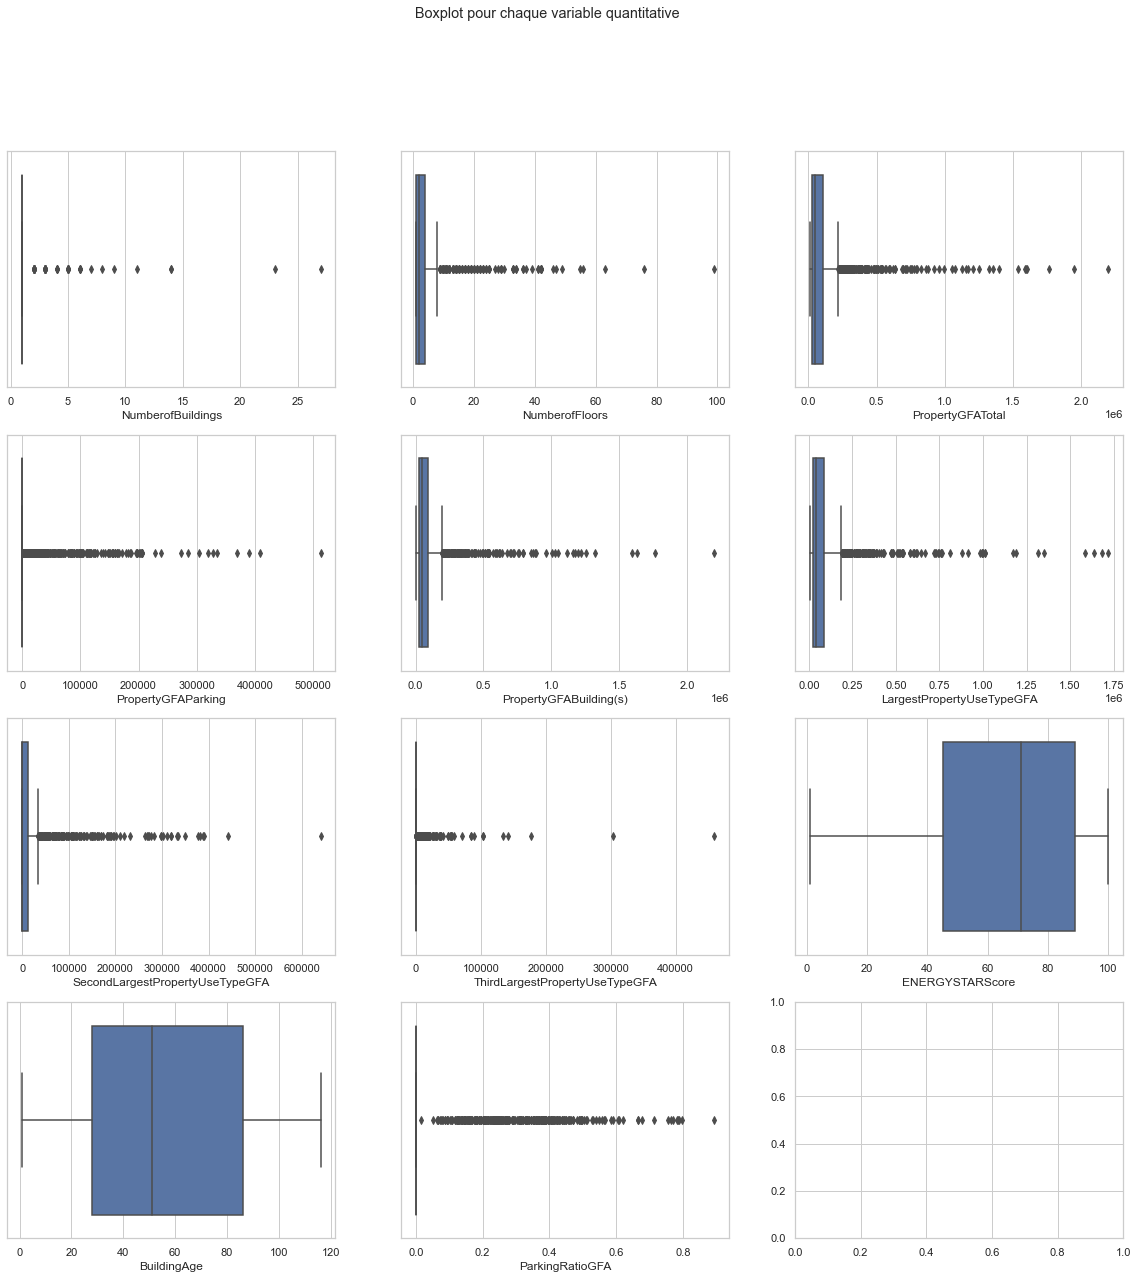

In [439]:
fc.multi_boxplot(data_final[col_quanti])

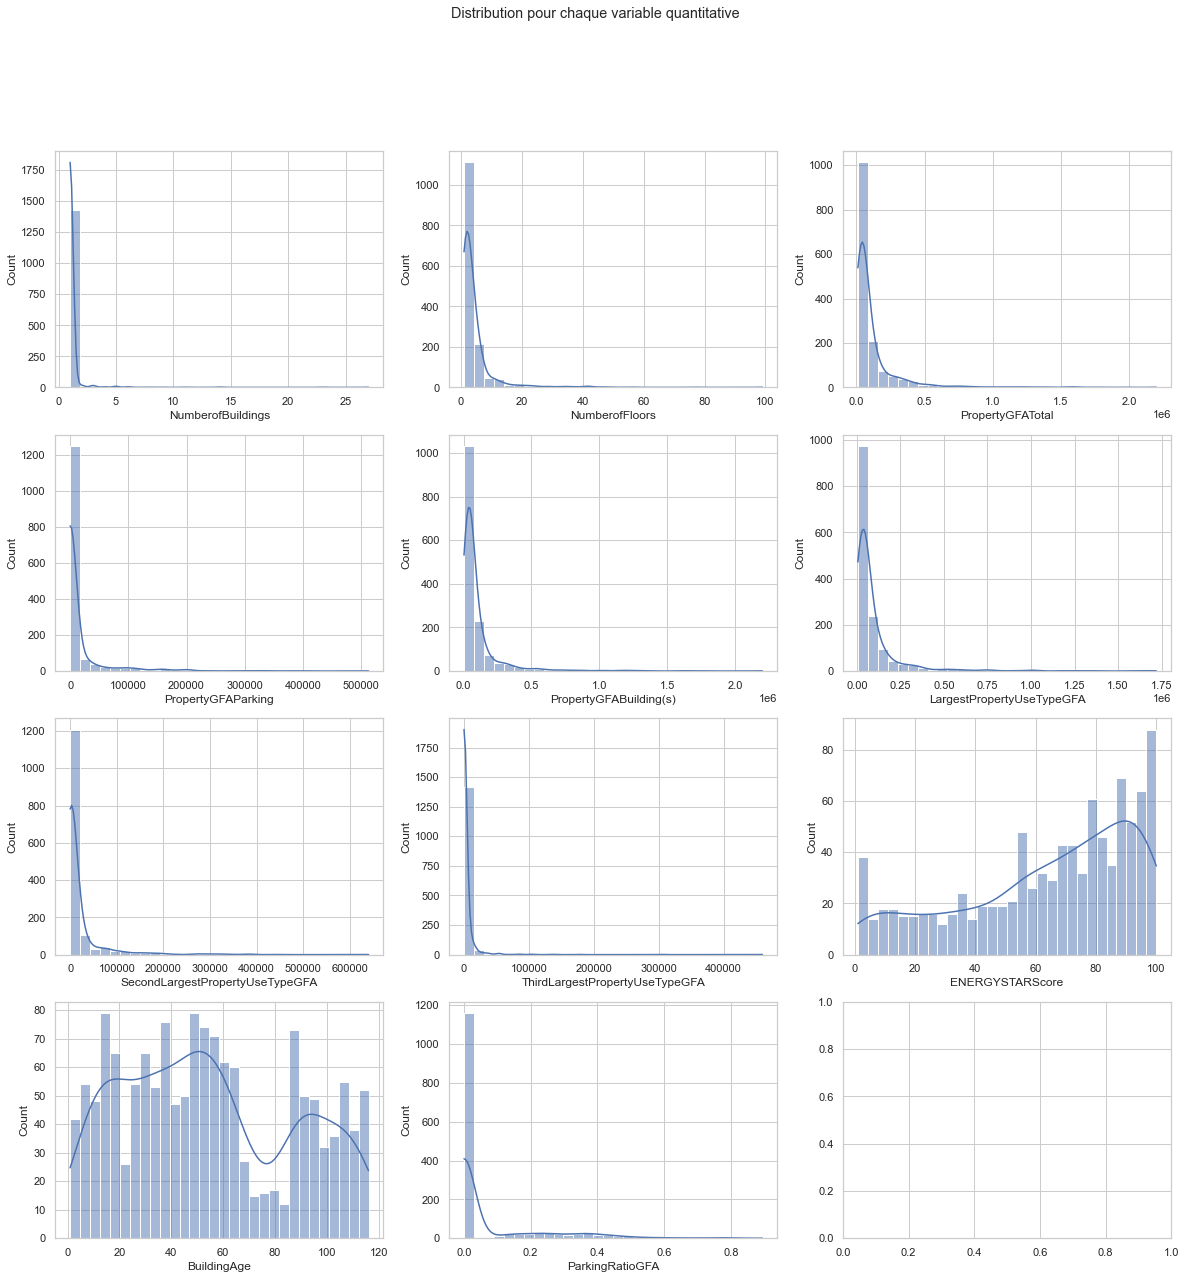

In [440]:
fc.distribution(data_final,col_quanti)

On peut constater que certaines variables semblent avoir une modalité majoritaire. 

In [441]:
fc.test_normalite(data_final,col_quanti,0.05)

Tests de normalité pour la variable NumberofBuildings.
                           Stat p-value Resultat
Shapiro Wilk           0.094551     0.0       H1
Anderson-Darling     522.292384     NaN       H1
K2 de D'Agostino    2869.015534     0.0       H1
Kolmogorov-Smirnov     0.841345     0.0       H1
----------------------------------------------------------------------
Tests de normalité pour la variable NumberofFloors.
                           Stat p-value Resultat
Shapiro Wilk           0.449672     0.0       H1
Anderson-Darling     230.737062     NaN       H1
K2 de D'Agostino    1693.661903     0.0       H1
Kolmogorov-Smirnov     0.841345     0.0       H1
----------------------------------------------------------------------
Tests de normalité pour la variable PropertyGFATotal.
                           Stat p-value Resultat
Shapiro Wilk           0.472044     0.0       H1
Anderson-Darling     236.879841     NaN       H1
K2 de D'Agostino    1502.736172     0.0       H1
Kolmogorov-

Les variables ne présentent pas de distribution normale.

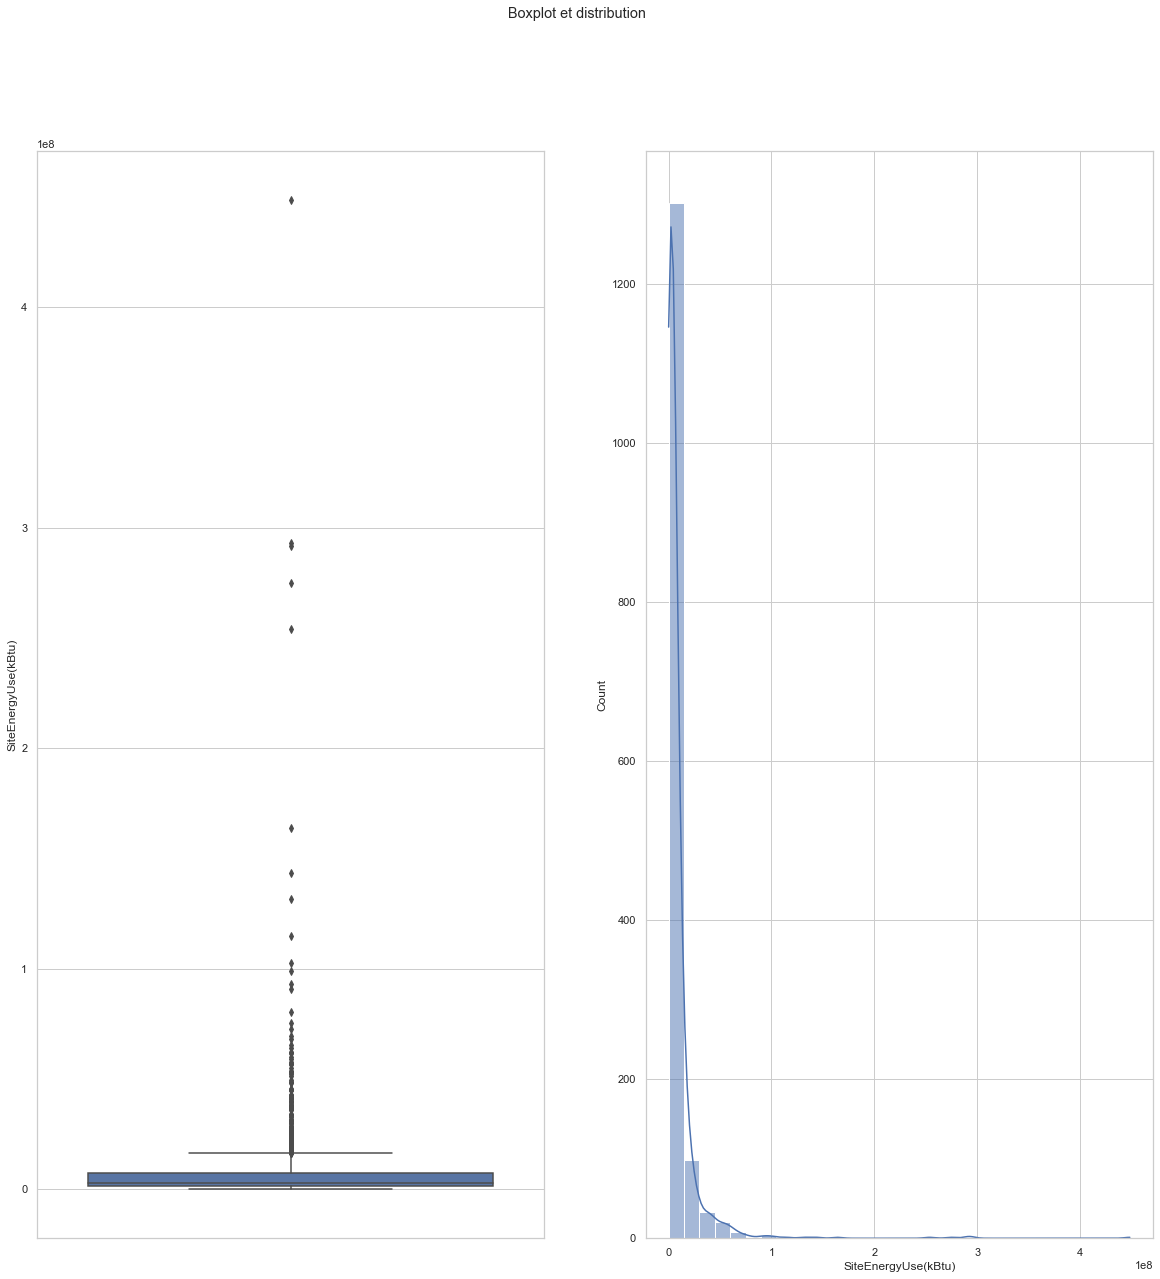

In [442]:
fc.box_hist(data_final,target[0])

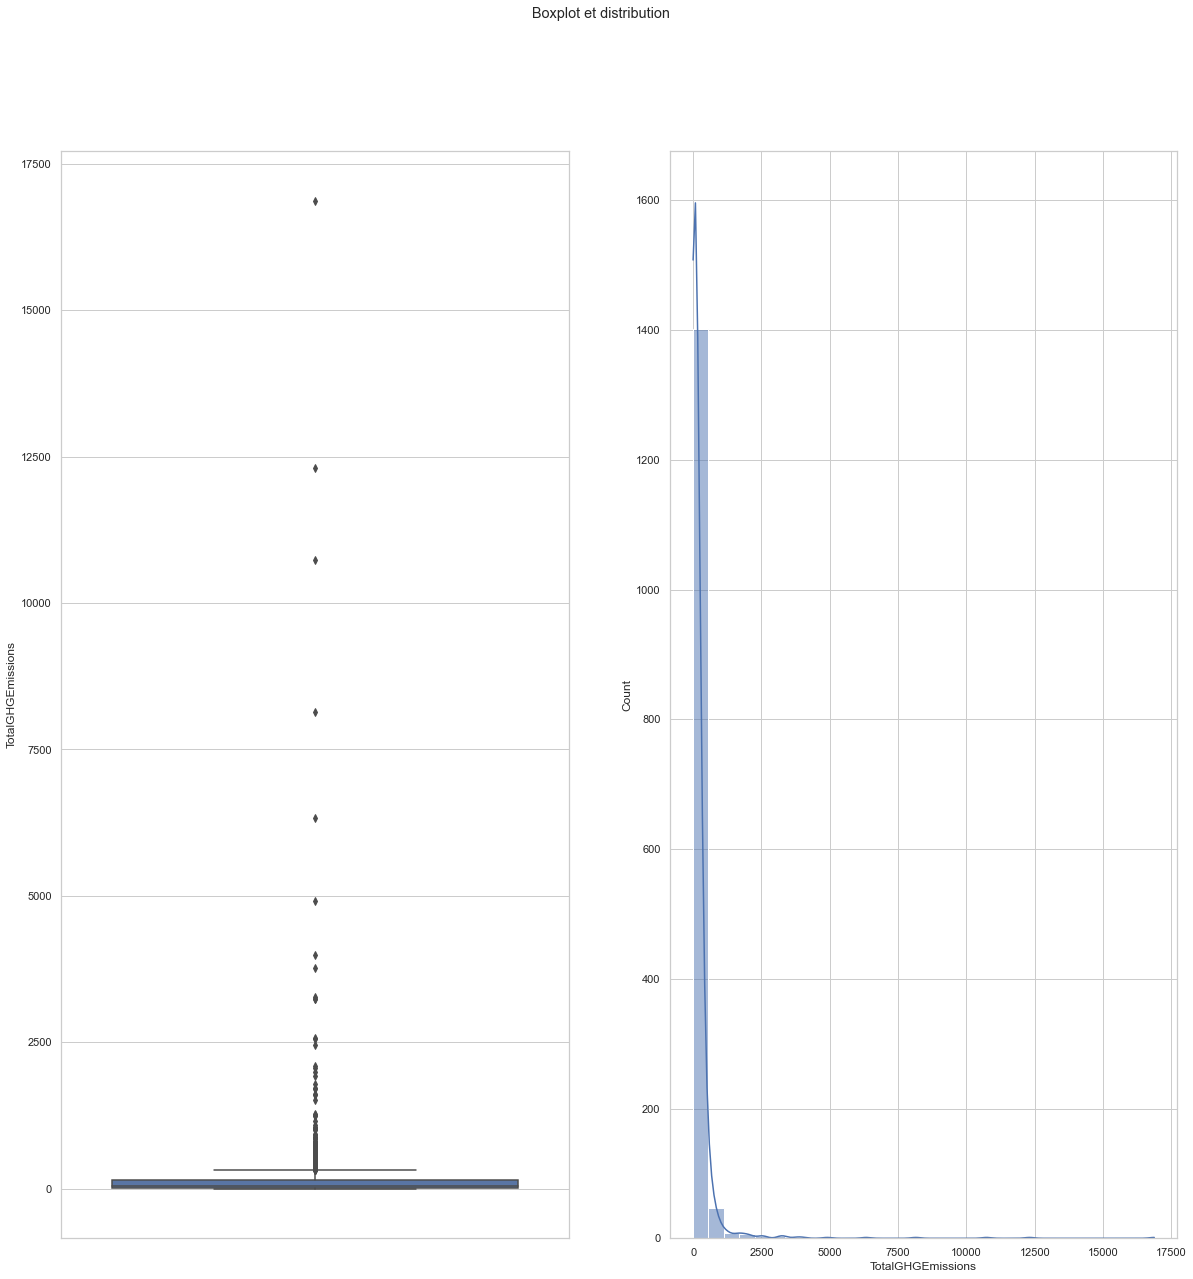

In [444]:
fc.box_hist(data_final,target[1])

In [445]:
fc.test_normalite(data_final,target,0.05)

Tests de normalité pour la variable SiteEnergyUse(kBtu).
                           Stat p-value Resultat
Shapiro Wilk           0.289505     0.0       H1
Anderson-Darling     293.954419     NaN       H1
K2 de D'Agostino    2450.681246     0.0       H1
Kolmogorov-Smirnov          1.0     0.0       H1
----------------------------------------------------------------------
Tests de normalité pour la variable SiteEnergyUseWN(kBtu).
                   Stat p-value Resultat
Shapiro Wilk        NaN     1.0       H0
Anderson-Darling    NaN     NaN      NaN
K2 de D'Agostino    NaN     NaN      NaN
Kolmogorov-Smirnov  NaN     NaN      NaN
----------------------------------------------------------------------
Tests de normalité pour la variable TotalGHGEmissions.
                           Stat p-value Resultat
Shapiro Wilk            0.17853     0.0       H1
Anderson-Darling      366.44347     NaN       H1
K2 de D'Agostino    2854.804645     0.0       H1
Kolmogorov-Smirnov     0.969876     0.0  

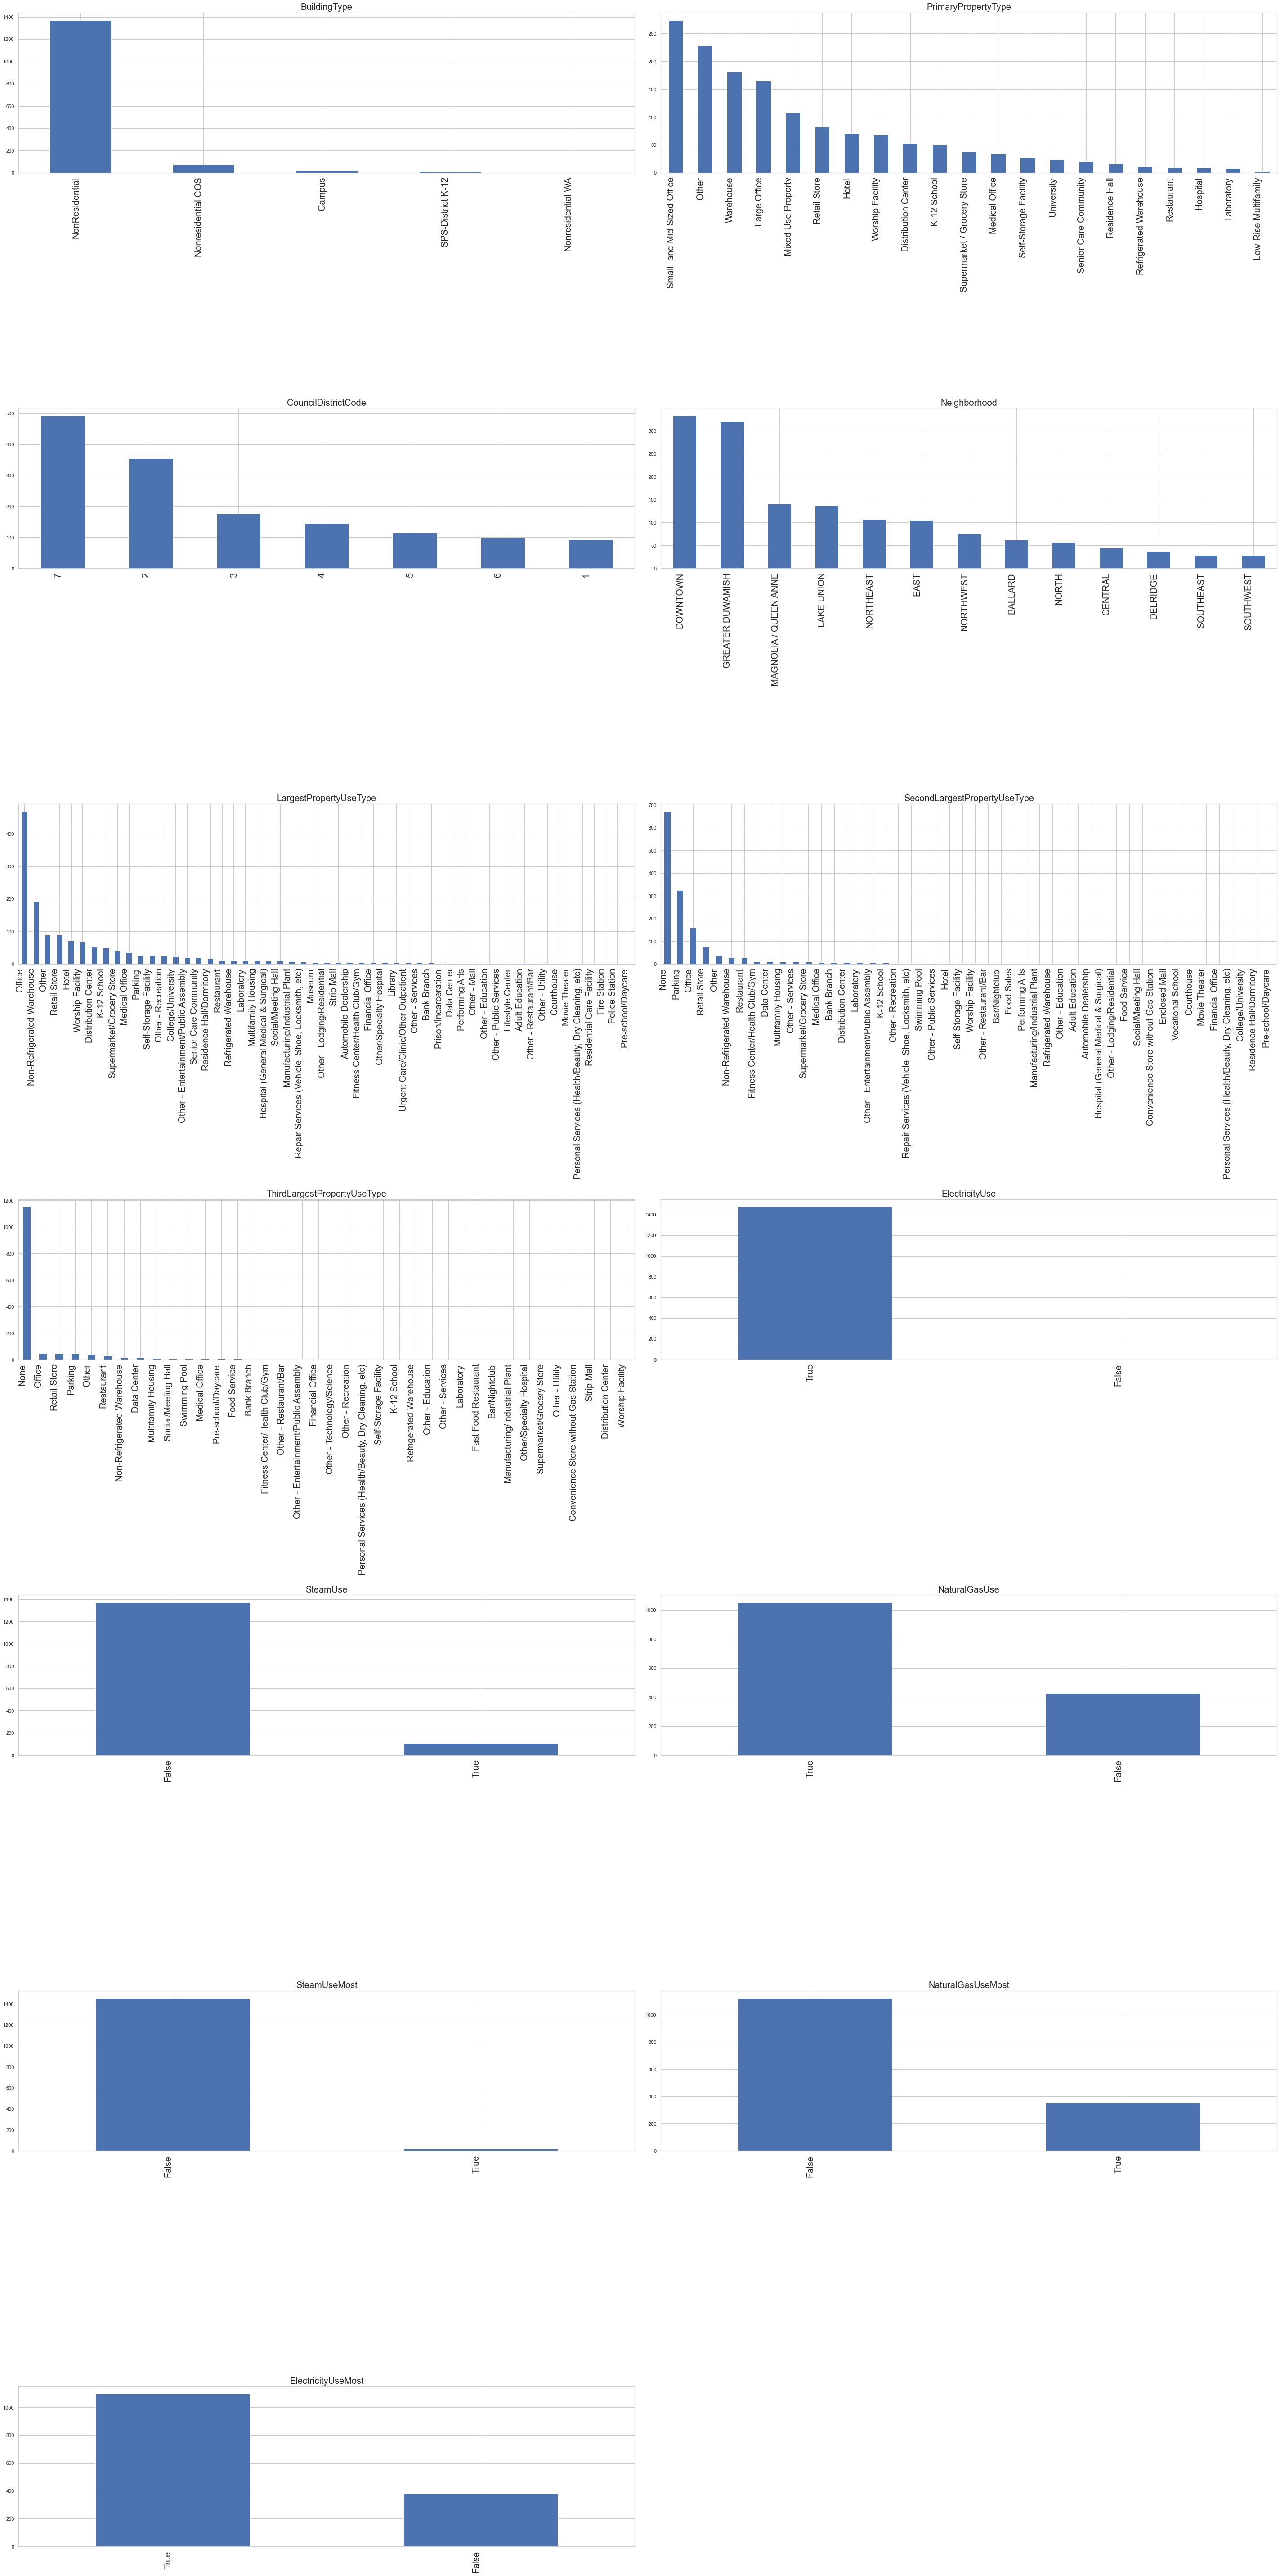

In [447]:
fc.bar_plot(data_final,col_quali)

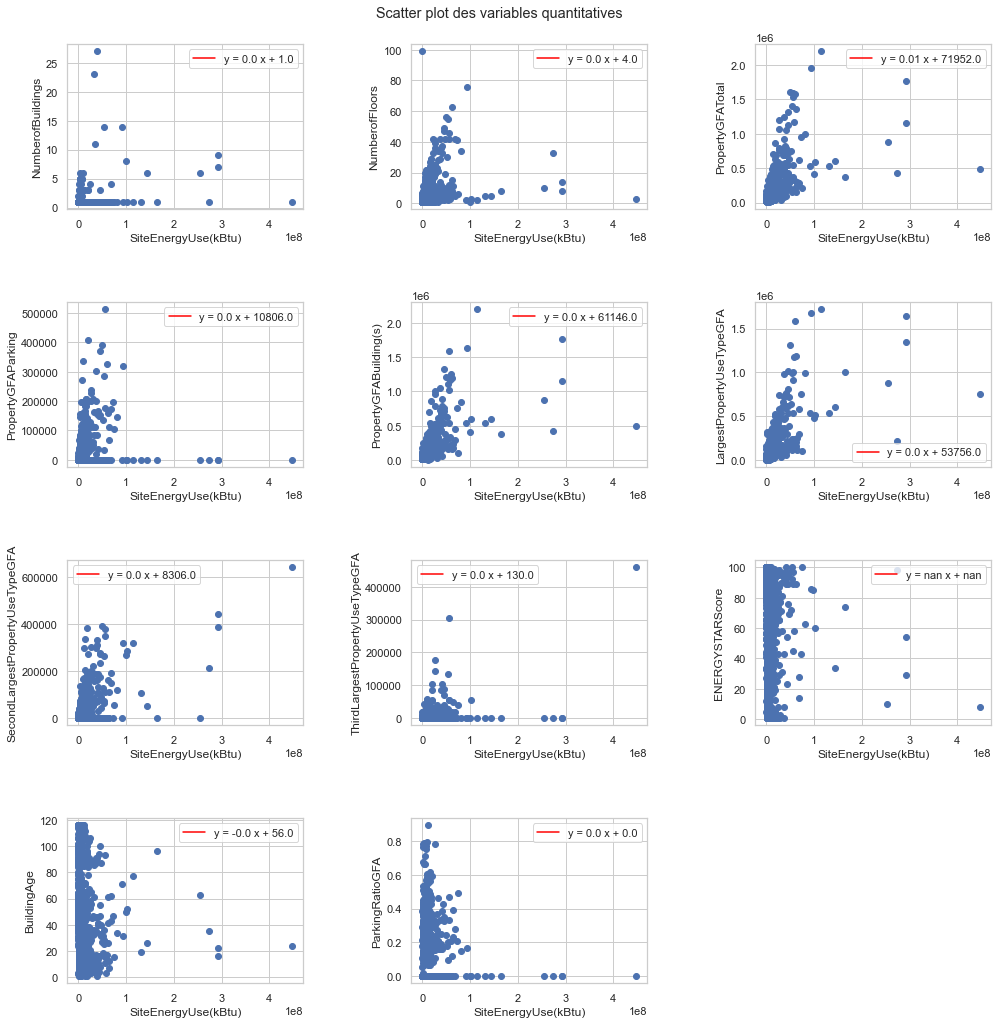

In [448]:
fc.scatter_plot(data_final,col_quanti, var_comparaison = target[0] ,largeur = 3,longueur=4)

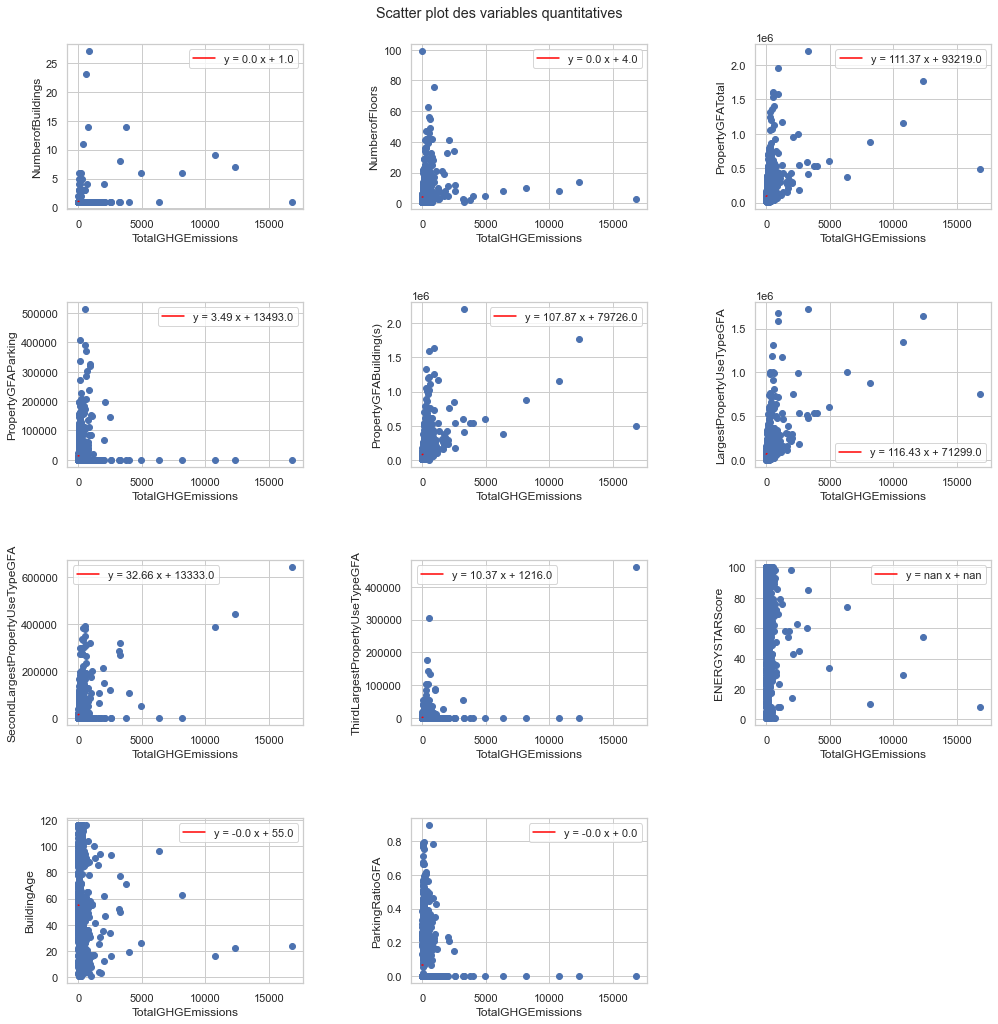

In [449]:
fc.scatter_plot(data_final,col_quanti, var_comparaison = target[2] ,largeur = 3,longueur=4)

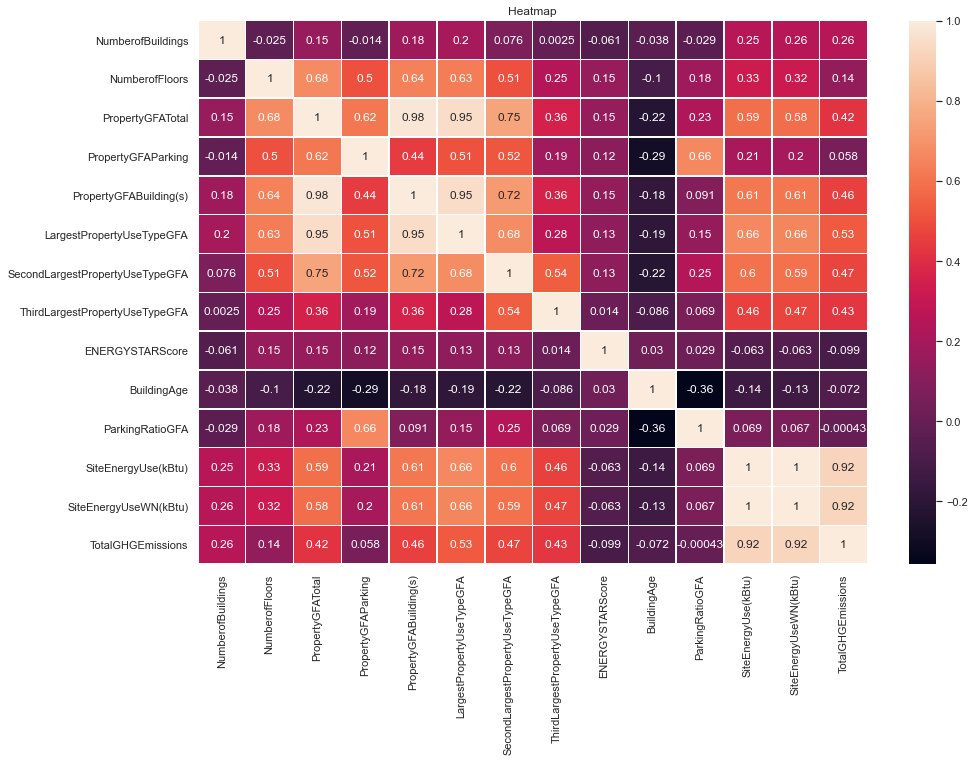

In [450]:
df_corr = data_final[col_quanti+target].corr()

fc.heat_map(df_corr)

On constate des corrélations importantes entre les variables suivantes : 
- PropertyGFABuilding(s) et PropertyGFATotal
- LargestPropertyUseTypeGFA et PropertyGFATotal
- LargestPropertyUseTypeGFA et PropertyGFABuilding(s)
- SecondLargestPropertyUseTypeGFA et PropertyGFATotal
- SecondLargestPropertyUseTypeGFA et PropertyGFABuilding(s)

Pour les variables à prédire *SiteEnergyUse(kBtu)* et *TotalGHGEmissions*, il existe des corrélations fortes avec PropertyGFABuilding(s), LargestPropertyUseTypeGFA et SecondLargestPropertyUseTypeGFA.

In [451]:
data_final['MoreThan1Building'] = (data_final['NumberofBuildings']>1).astype('category')

In [454]:
cols_to_drop = ['Latitude','Longitude','PropertyGFABuilding(s)','PropertyGFAParking','NumberofBuildings',
                'CouncilDistrictCode','BuildingType','PrimaryPropertyType']

In [455]:
data_final = data_final.drop(cols_to_drop,axis=1,errors='ignore')

In [456]:
col_quanti = ['NumberofFloors','PropertyGFATotal',
             'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
             'ENERGYSTARScore','BuildingAge','ParkingRatioGFA'
             ]

col_quali = ['Neighborhood','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType',
             'ElectricityUse','SteamUse','NaturalGasUse','SteamUseMost','NaturalGasUseMost','ElectricityUseMost']

target = ['SiteEnergyUse(kBtu)','TotalGHGEmissions']

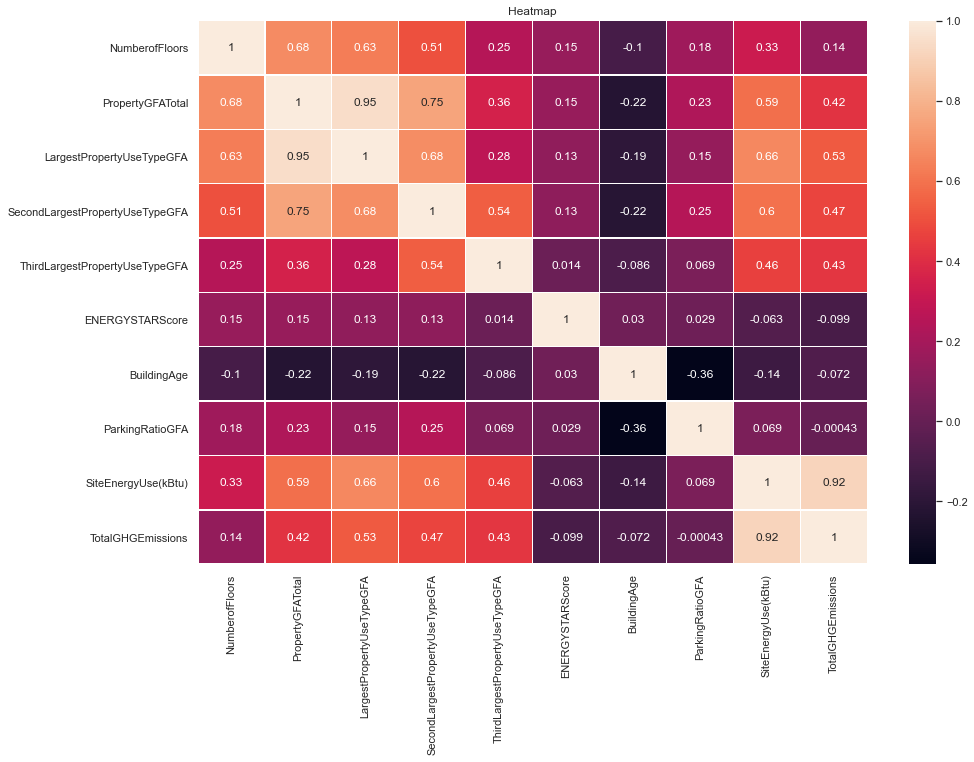

In [457]:
df_corr = data_final[col_quanti+target+col_quali].corr()

fc.heat_map(df_corr)

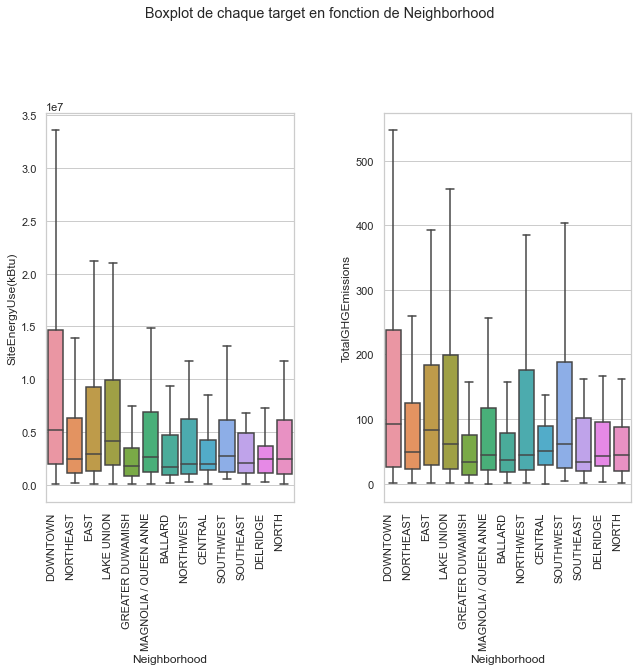

In [483]:
fc.boxplot_relation(data_final,target,'Neighborhood',1,2, outliers = False, option = True)

On constate que les target sont plus importantes dans les quartiers suivants : Downtown, East et Lake Union.

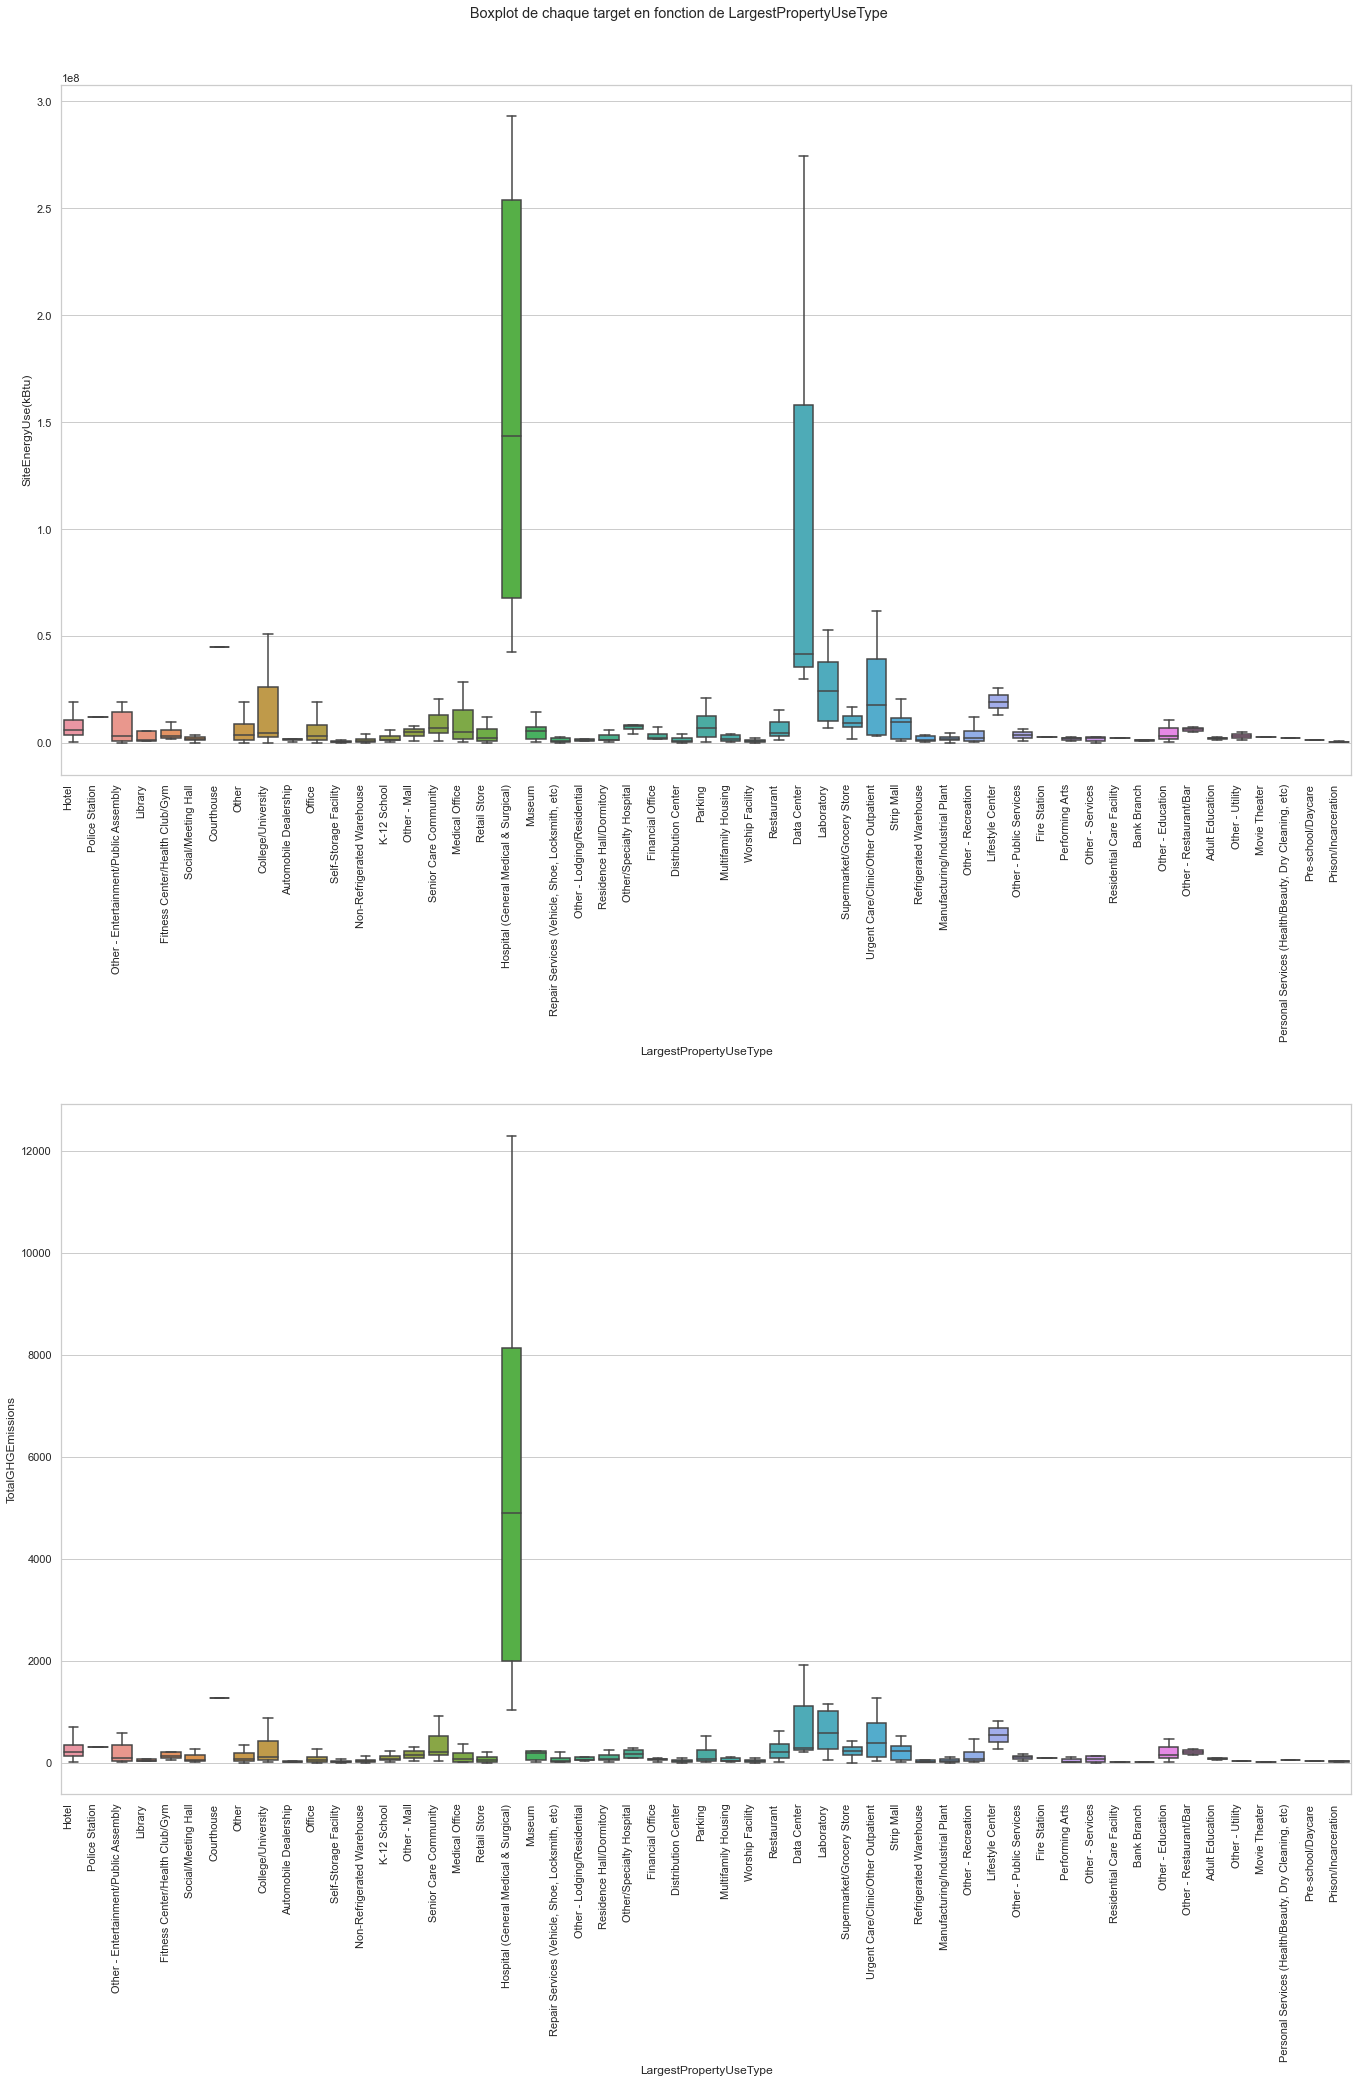

In [501]:
fc.boxplot_relation(data_final,target,'LargestPropertyUseType',2,1, outliers = False, option = True)

On constate que les bâtiments de type *Hospital* et *Data Center* possèdent des valeurs très importantes pour les deux target (*TotalGHGEmissions* et *SiteEnergyUse(kBtu)*).

In [459]:
data_final.dtypes

OSEBuildingID                         int64
Neighborhood                         object
NumberofFloors                        int64
PropertyGFATotal                      int64
LargestPropertyUseType               object
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType         object
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType          object
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
TotalGHGEmissions                   float64
BuildingAge                           int64
ElectricityUse                     category
SteamUse                           category
NaturalGasUse                      category
SteamUseMost                       category
NaturalGasUseMost                  category
ElectricityUseMost                 category
ParkingRatioGFA                     float64
MoreThan1Building                  category
dtype: object

In [460]:
data_final.head()

,OSEBuildingID,Neighborhood,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,ElectricityUse,SteamUse,NaturalGasUse,SteamUseMost,NaturalGasUseMost,ElectricityUseMost,ParkingRatioGFA,MoreThan1Building
0,1,DOWNTOWN,12,88434,Hotel,88434.0,None,0.0,None,0.0,60.0,7226362.5,249.98,89,True,True,True,False,False,True,0.000000,False
1,2,DOWNTOWN,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8387933.0,295.86,20,True,False,True,False,True,False,0.145453,False
2,3,DOWNTOWN,41,956110,Hotel,756493.0,None,0.0,None,0.0,43.0,72587024.0,2089.28,47,True,True,True,False,False,True,0.205748,False
3,5,DOWNTOWN,10,61320,Hotel,61320.0,None,0.0,None,0.0,56.0,6794584.0,286.43,90,True,True,True,False,False,True,0.000000,False
4,8,DOWNTOWN,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,14172606.0,505.01,36,True,False,True,False,True,False,0.353115,False


In [461]:
data_final.to_csv('data_cleaned.csv', index = False)